Hello all,

As spec. + 2D CNN are poplular in BirdCLEF, faster conversion of audio files to spectrograms is helpful to accelerate experiments. The common method to convert audio files to melspectrograms is based on `librosa` or `SciPy`. In this notebook, I want to introduce a faster method based on `CuPy`, which has been validated to be effective in another competition, [HMS-HBAC](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/overview), and helped me a lot.

**ATTENTION I**: As only CPU Notebook is allowed in inference, `CuPy` based conversion cannot be used in submission.

**ATTENTION II**: `CuPy` will fail with `P100`. Therefore, make sure using `T4` in this notebook. For more detailed discussion, please refer to this [issue](https://github.com/cupy/cupy/issues/8260) in CuPy's repo.

This notebook is based on @MARK WIJKHUIZEN's [notebook](https://www.kaggle.com/code/markwijkhuizen/birdclef-2024-eda-preprocessed-dataset) and the [discussion](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/487110) of @SERGEY SAHAROVSKIY in [HMS-HBAC](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/overview)

Hope this notebook is helpful for you.

## Update

- Update pre-processing to avoid NaN.
- I preprocessed the training data via CuPy. You can find it in this [dataset](https://www.kaggle.com/datasets/zijiangyang1116/birdclef24-spectrograms-via-cupy).

### P7
https://docs.pytorch.org/audio/main/generated/torchaudio.transforms.Spectrogram.html

# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm.notebook import tqdm

In [2]:
from scipy import signal as sci_signal
import cupy as cp
from cupyx.scipy import signal as cupy_signal

/opt/conda/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Configuration

In [3]:
class Config():
    
    # Sample Rate
    FS = 32000
    
    # make sure the spec. for each 5s audio data is [512, 512]
    N_FFT = 1095  # N FFT
    WIN_SIZE = 412  # WIN Size
    WIN_LAP = 100  # OVERLAP
    # min frequency
    MIN_FREQ = 40
    # max frequency
    MAX_FREQ = 15000
    # Competition Root Folder
    ROOT_FOLDER = '/kaggle/input/birdclef-2024'
    
CONFIG = Config()



# Metadata

In [4]:
train_metadata_df = pd.read_csv(
        '/kaggle/input/birdclef-2024/train_metadata.csv',
        dtype={
            'secondary_labels': 'string',
            'primary_label': 'category',
        },
    )

# Convert secondary_labels to iterable tuple
def parse_secondary_labels(s):
    s = s.strip("[']")
    s = s.split("', '")
    return tuple([e for e in s if len(e) > 0])

train_metadata_df['secondary_labels'] = train_metadata_df['secondary_labels'].apply(parse_secondary_labels)

# Number of samples
CONFIG.N_SAMPLES = len(train_metadata_df)
print(f'# Samples: {CONFIG.N_SAMPLES:,}')

display(train_metadata_df.head())
display(train_metadata_df.info())

# Samples: 24,459


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,(),['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,(),['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,(),['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,(),['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,(),['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   primary_label     24459 non-null  category
 1   secondary_labels  24459 non-null  object  
 2   type              24459 non-null  object  
 3   latitude          24081 non-null  float64 
 4   longitude         24081 non-null  float64 
 5   scientific_name   24459 non-null  object  
 6   common_name       24459 non-null  object  
 7   author            24459 non-null  object  
 8   license           24459 non-null  object  
 9   rating            24459 non-null  float64 
 10  url               24459 non-null  object  
 11  filename          24459 non-null  object  
dtypes: category(1), float64(3), object(8)
memory usage: 2.1+ MB


None

# Conversion

In [5]:
def oog2spec_via_cupy(audio_data):
    audio_data = cp.array(audio_data)
    
    # handles NaNs
    mean_signal = cp.nanmean(audio_data)
    audio_data = cp.nan_to_num(audio_data, nan=mean_signal) if cp.isnan(audio_data).mean() < 1 else cp.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = cupy_signal.spectrogram(
        audio_data, 
        fs=CONFIG.FS, 
        nfft=CONFIG.N_FFT, 
        nperseg=CONFIG.WIN_SIZE, 
        noverlap=CONFIG.WIN_LAP, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= CONFIG.MIN_FREQ) & (frequencies <= CONFIG.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = cp.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data.get()

In [6]:
def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data, 
        fs=CONFIG.FS, 
        nfft=CONFIG.N_FFT, 
        nperseg=CONFIG.WIN_SIZE, 
        noverlap=CONFIG.WIN_LAP, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= CONFIG.MIN_FREQ) & (frequencies <= CONFIG.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

### p7 code

In [7]:
import torch
import torchaudio
import numpy as np

def oog2spec_via_torchaudio(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)

    # Convert to torch tensor
    waveform = torch.tensor(audio_data, dtype=torch.float32).unsqueeze(0)  # shape: [1, T]

    # Create spectrogram transform
    spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=CONFIG.N_FFT,
        win_length=CONFIG.WIN_SIZE,
        hop_length=CONFIG.WIN_SIZE - CONFIG.WIN_LAP,
        window_fn=torch.hann_window,
        power=2.0,  # power=2 gives magnitude squared,
        normalized=False,
        center=False
    )

    # Compute spectrogram
    spec_data = spectrogram_transform(waveform)  # shape: [1, freq_bins, time_frames]
    spec_data = spec_data.squeeze(0).numpy()     # shape: [freq_bins, time_frames]

    # Get frequency vector
    freqs = np.fft.rfftfreq(CONFIG.N_FFT, d=1.0 / CONFIG.FS)

    # Filter frequency range
    valid_freq = (freqs >= CONFIG.MIN_FREQ) & (freqs <= CONFIG.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]

    # Log
    spec_data = np.log10(spec_data + 1e-20)

    # Normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()

    return spec_data


## Check of Consistency

make sure CuPy and Scipy generate same spectrograms.

In [8]:
test_audio_row = train_metadata_df.iloc[0]
test_file = f'{CONFIG.ROOT_FOLDER}/train_audio/{test_audio_row.filename}'
print(test_file)

# load file
audio_data, sample_rate = librosa.load(test_file, sr=CONFIG.FS)
print(audio_data.shape, sample_rate)

/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg
(875207,) 32000


In [9]:
# covert to spec. via CuPy
spec_cupy = oog2spec_via_cupy(audio_data)
# cover to spec. via scipy
spec_scipy = oog2spec_via_scipy(audio_data)
print(np.mean(spec_cupy - spec_scipy))

-2.4249377e-06


# comparison between scipy and torchaudio

| Parameter       | SciPy (`spectrogram`)     | torchaudio (`Spectrogram`)                    | Goal                                   |
| --------------- | ------------------------- | --------------------------------------------- | -------------------------------------- |
| `fs`            | sampling rate             | used only in manual freq calc                 | match in both (for `np.fft.rfftfreq`)  |
| `nfft`          | `nfft=CONFIG.N_FFT`       | `n_fft=CONFIG.N_FFT`                          | match                                  |
| `nperseg`       | `nperseg=CONFIG.WIN_SIZE` | `win_length=CONFIG.WIN_SIZE`                  | match                                  |
| `noverlap`      | `noverlap=CONFIG.WIN_LAP` | `hop_length=CONFIG.WIN_SIZE - CONFIG.WIN_LAP` | match                                  |
| `window='hann'` | Hann window               | `window_fn=torch.hann_window`                 | match                                  |
| **Padding**     | No padding (`mode='psd'`) | By default, **centered**, adds padding        | 🔥 set `center=False` in `Spectrogram` |


In [10]:

spec_scipy = oog2spec_via_scipy(audio_data)
spec_torchaudio=oog2spec_via_torchaudio(audio_data)
print(np.mean(spec_scipy-spec_torchaudio))

ValueError: operands could not be broadcast together with shapes (512,2804) (512,2802) 

Very small differences

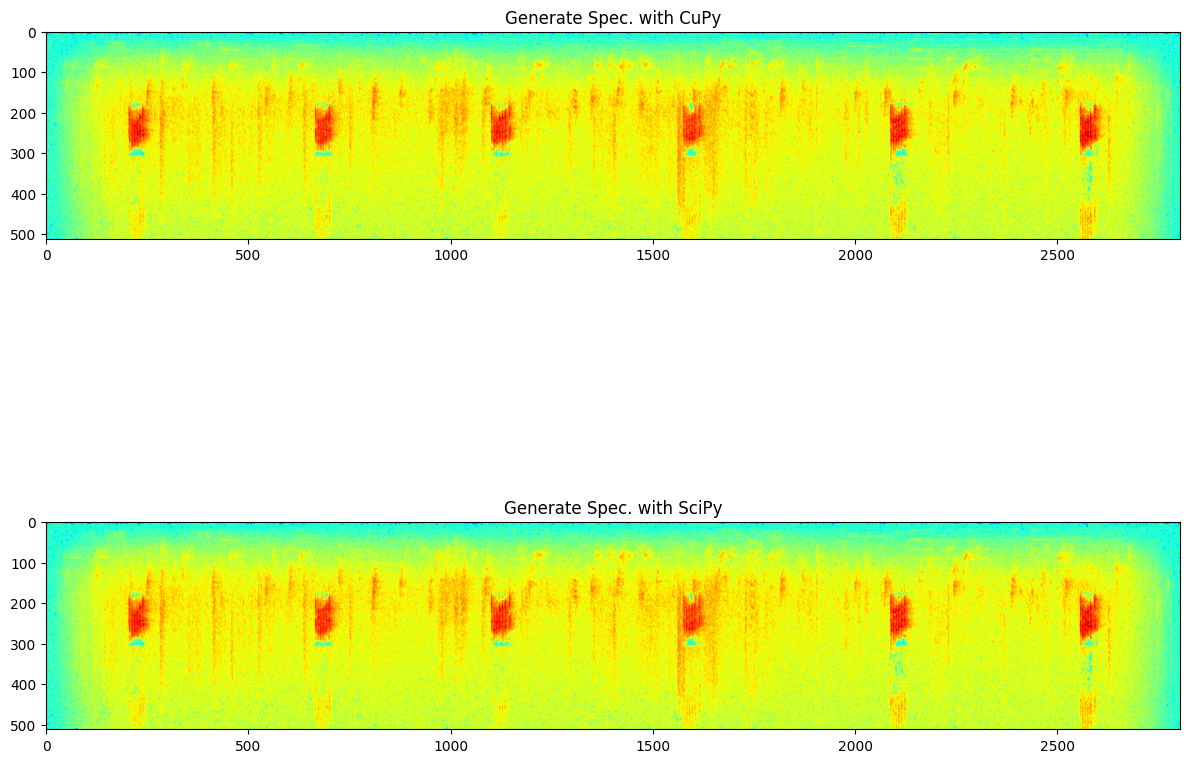

In [11]:
plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.imshow(spec_cupy, cmap='jet')
plt.title('Generate Spec. with CuPy')
plt.subplot(2, 1, 2)
plt.imshow(spec_scipy, cmap='jet')
plt.title('Generate Spec. with SciPy')
plt.tight_layout()
plt.show()

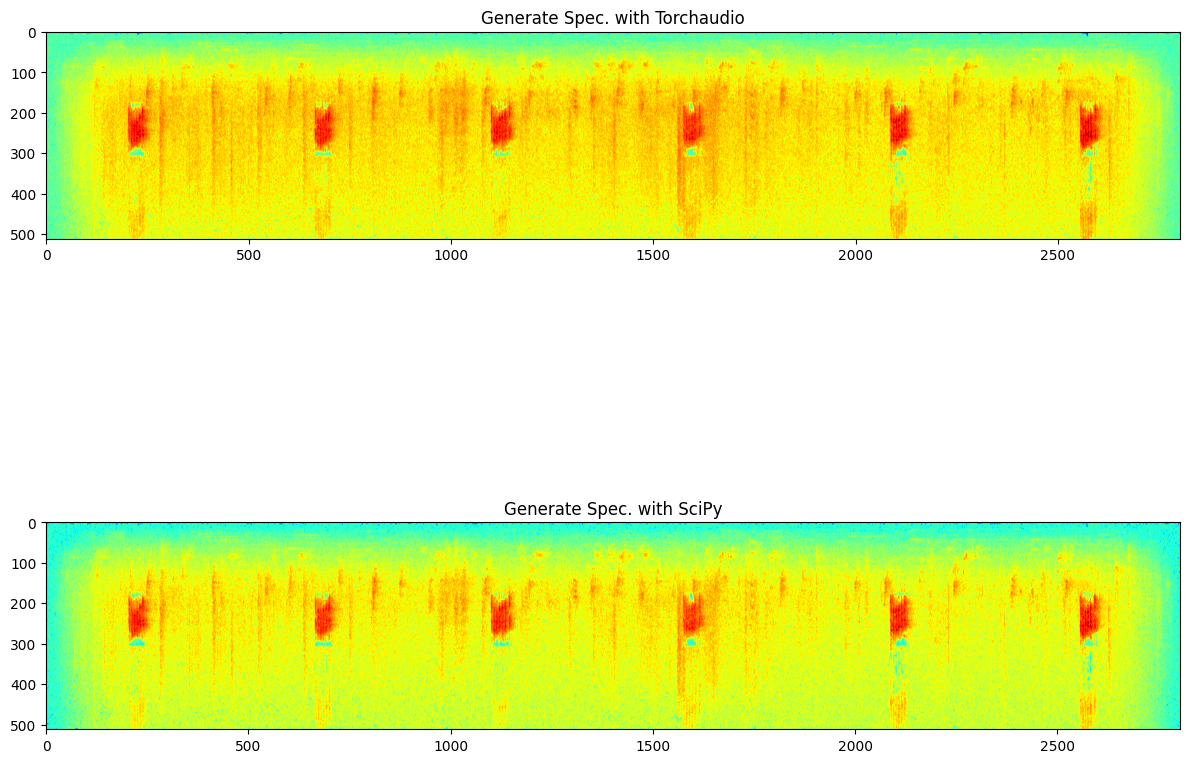

In [12]:
plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.imshow(spec_torchaudio, cmap='jet')
plt.title('Generate Spec. with Torchaudio')
plt.subplot(2, 1, 2)
plt.imshow(spec_scipy, cmap='jet')
plt.title('Generate Spec. with SciPy')
plt.tight_layout()
plt.show()

CuPy and Scipy can generate consistent spectrograms. Therefore, CuPy can be used locally to accelerate experiments, while Scipy can be used for inference to ensure consistency of preprocessing.

# manual truncation

In [13]:
min_time_frames = min(spec_scipy.shape[1], spec_torchaudio.shape[1])
spec_scipy_aligned = spec_scipy[:, :min_time_frames]
spec_torchaudio_aligned = spec_torchaudio[:, :min_time_frames]
print(np.mean(spec_scipy_aligned - spec_torchaudio_aligned))

-0.03682855


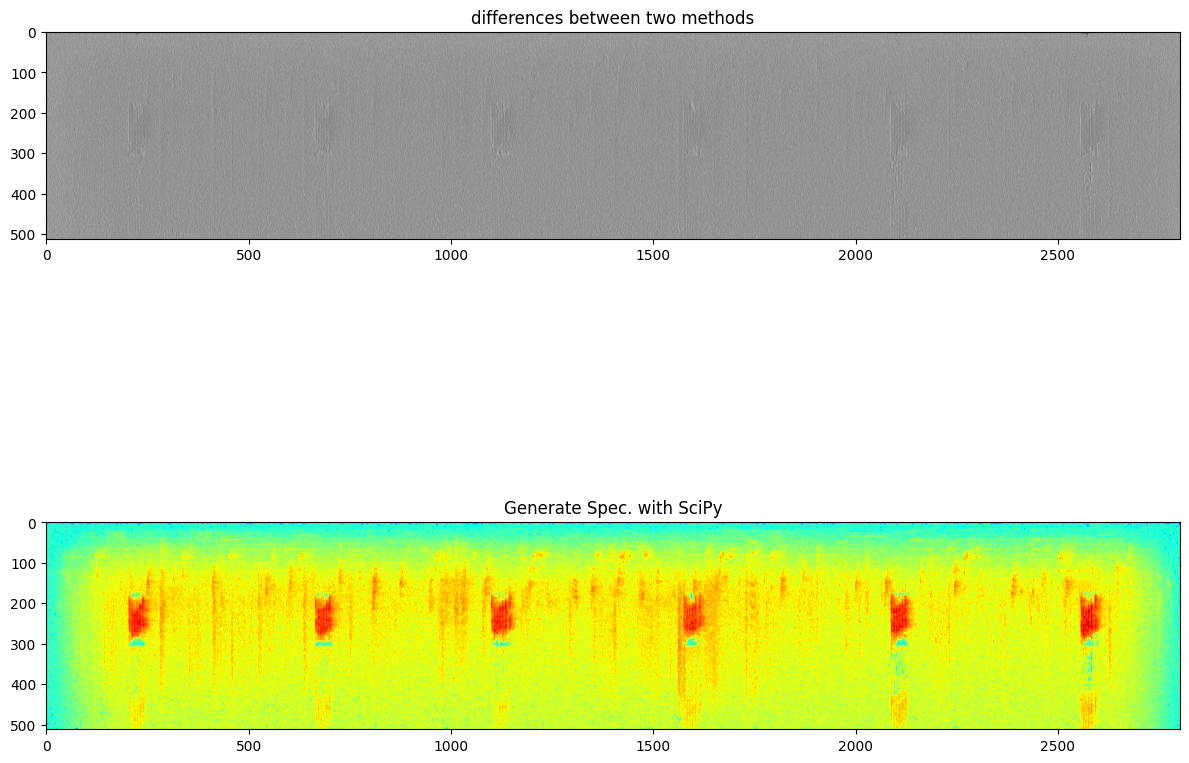

In [14]:
plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.imshow(spec_torchaudio_aligned-spec_scipy_aligned, cmap='gray')
plt.title('differences between two methods')
plt.subplot(2, 1, 2)
plt.imshow(spec_scipy_aligned, cmap='jet')
plt.title('Generate Spec. with SciPy')
plt.tight_layout()
plt.show()

### plot of diffrences between the two methods

/tmp/ipykernel_34/4005562153.py:8: RuntimeWarning: invalid value encountered in log
  difference = np.log((spec_torchaudio_aligned - spec_scipy_aligned)+1e-40)


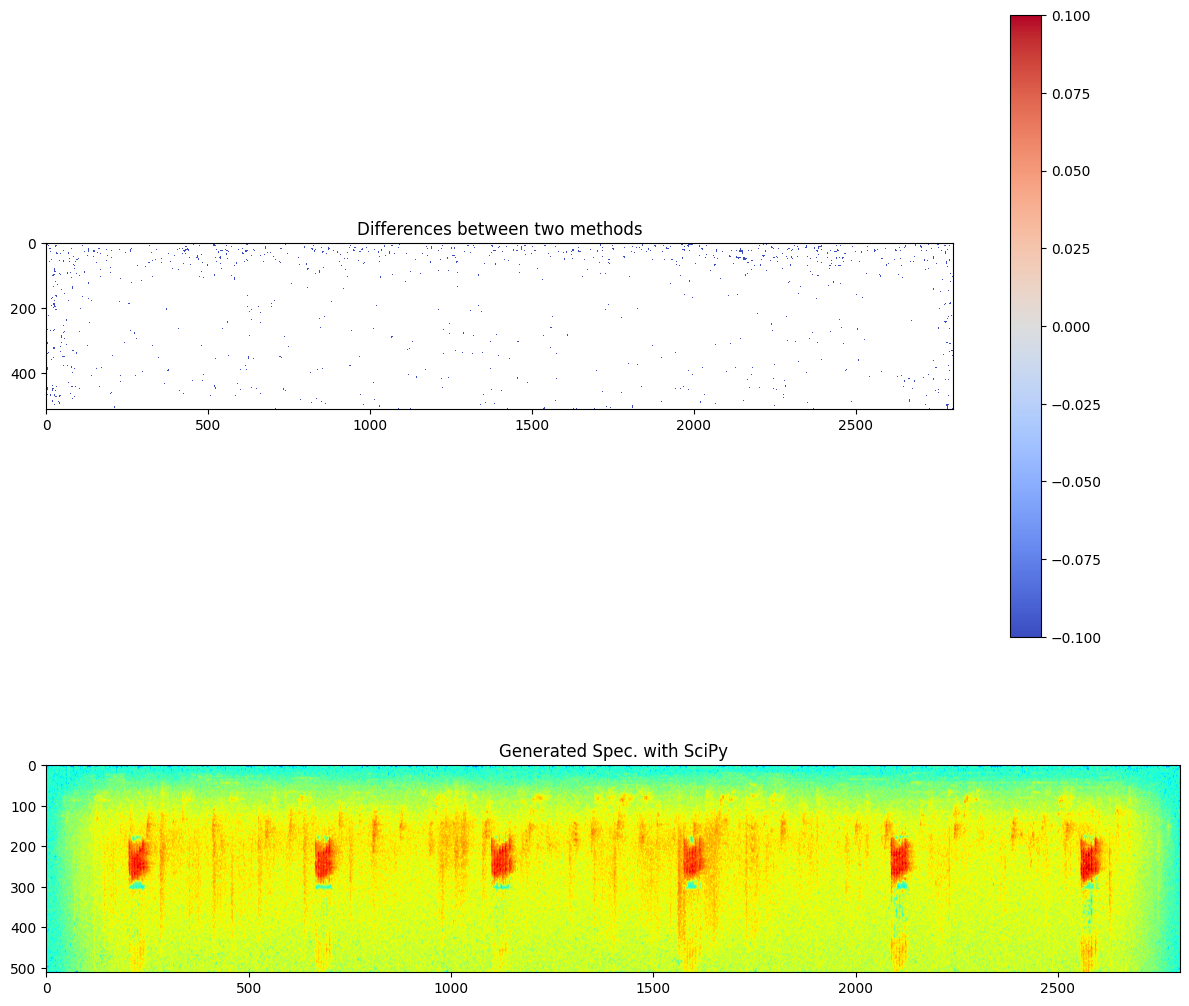

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.figure(figsize=(12, 12))

# First subplot with enhanced difference visibility
plt.subplot(2, 1, 1)
difference = np.log((spec_torchaudio_aligned - spec_scipy_aligned)+1e-40)
norm = colors.Normalize(vmin=-abs(difference).max(), vmax=abs(difference).max()) # Normalize based on the maximum absolute difference
plt.imshow(difference, cmap='coolwarm', norm=norm) # Using 'coolwarm' colormap
plt.title('Differences between two methods')
plt.colorbar() # Adding a colorbar to show the scale

# Second subplot remains the same
plt.subplot(2, 1, 2)
plt.imshow(spec_scipy_aligned, cmap='jet')
plt.title('Generated Spec. with SciPy')

plt.tight_layout()
plt.show()


## Comparision of Speed

In [16]:
import time
from tqdm import tqdm

n_max = 100

begin_time = time.time()
for i in tqdm(range(n_max)):
    spec_cupy = oog2spec_via_cupy(audio_data)
end_time = time.time()

print(f'CuPy: {(end_time - begin_time) / n_max:.4f} sec/sample')

begin_time = time.time()
for i in tqdm(range(n_max)):
    spec_scipy = oog2spec_via_scipy(audio_data)
end_time = time.time()

print(f'SciPy: {(end_time - begin_time) / n_max:.4f} sec/sample')

begin_time = time.time()
for i in tqdm(range(n_max)):
    spec_scipy = oog2spec_via_torchaudio(audio_data)
end_time = time.time()

print(f'TorchAudio: {(end_time - begin_time) / n_max:.4f} sec/sample')

100%|██████████| 100/100 [00:00<00:00, 188.91it/s]


CuPy: 0.0053 sec/sample


100%|██████████| 100/100 [00:06<00:00, 15.78it/s]


SciPy: 0.0634 sec/sample


100%|██████████| 100/100 [00:06<00:00, 16.61it/s]

TorchAudio: 0.0603 sec/sample


A very significant improvement!!! CuPy is x11 faster than Scipy with Nvidia T4!!!

first implementation of fft neural model

In [17]:
import torch
import torch.nn as nn
import torchaudio

class Spectrogram_Layer(nn.Module):
    def __init__(self, n_fft, win_size, hop_size, fs, min_freq, max_freq):
        super().__init__()
        self.n_fft = n_fft
        self.win_size = win_size
        self.hop_size = hop_size
        self.fs = fs
        self.min_freq = min_freq
        self.max_freq = max_freq

        self.spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=n_fft,
            win_length=win_size,
            hop_length=hop_size,
            window_fn=torch.hann_window,
            power=2.0,
            normalized=False,
            center=False
        )

        freqs = torch.fft.rfftfreq(n_fft, d=1.0 / fs)
        self.register_buffer("valid_freq_mask", (freqs >= min_freq) & (freqs <= max_freq))

    def forward(self, x):
        # x: (batch, time)
        if torch.isnan(x).any():
            mean_val = torch.nanmean(x)
            x = torch.nan_to_num(x, nan=mean_val.item())
        
        x = x.unsqueeze(1)  # (batch, 1, time)
        spec = self.spectrogram(x)  # (batch, freq_bins, time)
        spec = spec[:, self.valid_freq_mask, :]  # Filter freqs
        spec = torch.log10(spec + 1e-20)
        spec = (spec - spec.min()) / (spec.max() - spec.min())
        return spec


    FS = 32000
    
    # make sure the spec. for each 5s audio data is [512, 512]
    N_FFT = 1095  # N FFT
    WIN_SIZE = 412  # WIN Size
    WIN_LAP = 100  # OVERLAP
    # min frequency
    MIN_FREQ = 40
    # max frequency
    MAX_FREQ = 15000

In [18]:

model=Spectrogram_Layer(n_fft=CONFIG.N_FFT, win_size=CONFIG.WIN_SIZE, hop_size=CONFIG.WIN_SIZE-CONFIG.WIN_LAP, fs=CONFIG.FS, min_freq=CONFIG.MIN_FREQ, max_freq=CONFIG.MAX_FREQ)
model.eval()

test_audio_row = train_metadata_df.iloc[0]
test_file = f'{CONFIG.ROOT_FOLDER}/train_audio/{test_audio_row.filename}'
print(test_file)

# load file
audio_data, sample_rate = librosa.load(test_file, sr=CONFIG.FS)
print(audio_data.shape, sample_rate)

input_model=torch.from_numpy(audio_data)

outputs=model(input_model)




/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg
(875207,) 32000


RuntimeError: stft(torch.FloatTensor[875207, 1], n_fft=1095, hop_length=312, win_length=412, window=torch.FloatTensor{[412]}, normalized=0, onesided=1, return_complex=1) : expected 0 < n_fft < 1, but got n_fft=412

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LearnableSpectrogram(nn.Module):
    def __init__(self, in_channels=1, n_filters=64, kernel_size=256, stride=128, apply_log=True):
        super(LearnableSpectrogram, self).__init__()
        self.apply_log = apply_log
        
        # Convolutional filterbank (learnable)
        self.conv = nn.Conv1d(in_channels, n_filters, kernel_size, stride=stride)

        # Optional batch norm
        self.bn = nn.BatchNorm1d(n_filters)

    def forward(self, x):
        """
        x: (batch, time) → assumes mono audio waveform
        returns: (batch, filters, time_frames)
        """
        if x.ndim == 2:
            x = x.unsqueeze(1)  # (batch, 1, time)

        x = self.conv(x)          # (batch, n_filters, time_frames)
        x = torch.abs(x)          # Magnitude of response
        x = self.bn(x)

        if self.apply_log:
            x = torch.log1p(x)    # Log-magnitude

        return x
model=LearnableSpectrogram()
model.eval()

test_audio_row = train_metadata_df.iloc[0]
test_file = f'{CONFIG.ROOT_FOLDER}/train_audio/{test_audio_row.filename}'
print(test_file)

# load file
audio_data, sample_rate = librosa.load(test_file, sr=CONFIG.FS)
print(audio_data.shape, sample_rate)
input_model = torch.from_numpy(audio_data).unsqueeze(0).unsqueeze(0) 
#input_model=torch.from_numpy(audio_data)
print(input_model.shape)
outputs=model(input_model)
print(outputs.shape)

/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg
(875207,) 32000
torch.Size([1, 1, 875207])
torch.Size([1, 64, 6836])


# GARBAGE CODE BELOW

In [21]:
import torch
import torch.nn as nn
class Spectrogram_Layer(nn.Module):
    def __init__(self):
        super(Spectrogram_Layer, self,n_fft, win_size, hop_size, fs, min_freq, max_freq).__init__()
        self.n_fft = n_fft
        self.win_size = win_size
        self.hop_size = hop_size
        self.fs = fs
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.spectrogramm=torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_size,
        hop_length=CONFIG.WIN_SIZE - CONFIG.WIN_LAP,
        window_fn=torch.hann_window,
        power=2.0,  # power=2 gives magnitude squared,
        normalized=False,
        center=False
    )

    def forward(self, x):
        #self.mean_signal = np.nanmean(x)
        #self.audio_data = np.nan_to_num(x, nan=self.mean_signal) if np.isnan(x).mean() < 1 else np.zeros_like(x)
        nan_mask = torch.isnan(x)
        if nan_mask.any():
            mean_signal = torch.nanmean(x)
            x = torch.where(nan_mask, mean_signal, x)
            
        # Convert to torch tensor
        self.waveform = torch.tensor(self.audio_data, dtype=torch.float32).unsqueeze(0)
        
        self.spec_data=self.spectrogramm(self.waveform)

        self.spec_data = self.spec_data.squeeze(0).numpy()     # shape: [freq_bins, time_frames]

        # Get frequency vector
        self.freqs = np.fft.rfftfreq(CONFIG.N_FFT, d=1.0 / CONFIG.FS)

        # Filter frequency range
        self.valid_freq = (self.freqs >= CONFIG.MIN_FREQ) & (self.freqs <= CONFIG.MAX_FREQ)
        self.spec_data = self.spec_data[self.valid_freq, :]

        # Log
        self.spec_data = np.log10(self.spec_data + 1e-20)

        # Normalize
        self.spec_data = self.spec_data - self.spec_data.min()
        self.spec_data = self.spec_data / self.spec_data.max()
        return self.spec_data

model=Spectrogram_Layer()
print(model)

NameError: name 'n_fft' is not defined